# Coursera IBM Capstone Project: selecting the best city for opening a vegan or vegetarian restaurant 

In this report, I will describe how I combined multiple data sources to build a scoring model that predicts which of the Dutch cities is best suited for opening a vegan or vegetarian restaurant. I’ve combined the following sources of data for this project: 
-	The Foursquare API, to retrieve information on existing restaurants per city. 
-	The government’s Central Bureau of Statistics (CBS) data, to retrieve regional demographic and economic information (1).
-	Funda in Business, the largest real estate website, for the average retail property price. (2)
-	The National Institute for Public Health and the Environment (RIVM), for data on people’s eating habits (3).

From this data, I’ve distilled 5 variables that add up to produce a suitability score for each city. This quantitative tool will not provide definitive answers as to which city is ‘best’ in an absolute sense. It will, however, provide future restaurant owners with a short-list of cities for more in-depth, qualitative analysis.


In [1]:
#import all libraries
import geocoder 
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re #regular expressions
import statistics as st
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import folium

## 1. Create a list of Municipalities and their population


In [2]:
#open CBS Statline data to obtain citie names and inhabitants
cbs = pd.read_csv('Regionale_kerncijfers_Nederland_05012021_213538.csv', delimiter=';')
cbs.head()

,Perioden,Regio's,Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/Jonger dan 5 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/5 tot 10 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/10 tot 15 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/15 tot 20 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/20 tot 25 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/25 tot 45 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/45 tot 65 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/65 tot 80 jaar (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen/80 jaar of ouder (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Stedelijkheidsklasse/Zeer sterk stedelijk (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Stedelijkheidsklasse/Sterk stedelijk (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Stedelijkheidsklasse/Matig stedelijk (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Stedelijkheidsklasse/Weinig stedelijk (aantal),Bevolking/Bevolkingssamenstelling op 1 januari/Stedelijkheidsklasse/Niet stedelijk (aantal),Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld gestandaardiseerd inkomen/Particuliere huishoudens excl. studenten (1 000 euro)
0,2020,Aa en Hunze,25445.0,946.0,1160.0,1354.0,1545.0,1079.0,4375.0,8249.0,5166.0,1571.0,0.0,0.0,0.0,4140.0,21310.0,NaN
1,2020,Aalburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,Aalsmeer,31859.0,1432.0,1928.0,2217.0,2146.0,1606.0,7073.0,9545.0,4402.0,1510.0,0.0,10.0,16140.0,13030.0,2690.0,NaN
3,2020,Aalten,27121.0,1205.0,1353.0,1659.0,1689.0,1364.0,5438.0,8301.0,4641.0,1471.0,0.0,0.0,8490.0,10570.0,8060.0,NaN
4,2020,Ter Aar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#rename columns
cbs.rename(columns = {'Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal)' : 'Population'}, inplace=True)
cbs.rename(columns = {"Regio's" : 'Municipalities'}, inplace=True)

#drop columns and NaN values
cbs.drop('Perioden', axis =1, inplace=True)
cbs.dropna(subset = ['Population'], axis = 0, inplace=True)

#change values to int
cbs.Population = cbs.Population.astype('int')

In [4]:
#filter out all municipalities below 100.000 inhabitants
mask = cbs['Population'] >= 100000
cbs = cbs[mask]




In [5]:
cbs.sort_values('Population', ascending=False, inplace=True)

#remove the municipality that is not also a city
cbs = cbs[cbs['Municipalities'] != 'Westland']


In [6]:
#extract the useful coloumns to a new dataframe (df)
df = cbs[['Municipalities', 'Population']]

In [7]:
df.reset_index(inplace=True, drop= True)

In [8]:
# remove unnecvessary parts from the names
df['Municipalities'] = df['Municipalities'].str.replace('gemeente', '')
df['Municipalities'] = df['Municipalities'].str.replace(r"\(\)","")
#Applying the strip function to get rid of any ending whitespace characters
df['Municipalities'] = df['Municipalities'].str.strip()                                              


<ipython-input-8-a218dad6a749>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Municipalities'] = df['Municipalities'].str.replace('gemeente', '')
<ipython-input-8-a218dad6a749>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Municipalities'] = df['Municipalities'].str.replace(r"\(\)","")
<ipython-input-8-a218dad6a749>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

## 2. Add location data for the cities in the dataframe

In [9]:
#save to new df to csv
df.to_csv('df.csv')

In [10]:
# load saved file to prevent continues get requests from ArcGis
df = pd.read_csv('df.csv', index_col = 0)
df.shape

(31, 2)

## 3. Getting Vegeterian Venue data from Foursquare

In [11]:
# foursquare credentials
CLIENT_ID = 'BBTDTWA2S3FONQ2KK5BBRIS2VHF0CMFLMFMZ22YETQGGQDUN' # your Foursquare ID
CLIENT_SECRET = 'KHX3XJ1OYF2PGHC4YGPP1DP3QHWQ3JWYNA2C1DQX2JFEY2YB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value
CATEGORY = '4bf58dd8d48988d1d3941735' # Vegetarian / Vegan Restaurant
radius = 10000
#latitude = 52.36993 #amsterdam
#longitude = 4.90788 #amsterdam

In [12]:
#define a function that creates a new dataframe (nearby_venues) that list all vegeterian venues for each city
def getNearbyVenues(municipalities, latitudes, longitudes):
    
    venues_list=[]
    for muni, lat, lng in zip(municipalities, latitudes, longitudes):
        print(muni)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            radius, 
            LIMIT, 
            CATEGORY)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            muni, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipalities', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [13]:
#load saved vegetarian venues
veg_venues = pd.read_csv('veg_venues.csv', index_col = 0)

In [14]:
veg_venues.head()

,Municipalities,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Amsterdam,52.36993,4.90788,Restaurant de Waaghals,52.357151,4.888920
1,Amsterdam,52.36993,4.90788,Vegan Junk Food Bar,52.357107,4.891184
2,Amsterdam,52.36993,4.90788,Mr. & Mrs. Watson,52.355306,4.929017
3,Amsterdam,52.36993,4.90788,Le Sud,52.383254,4.886161
4,Amsterdam,52.36993,4.90788,Vegan Junk Food Bar,52.366391,4.891563


In [15]:
#amount of veg restaurants
veg_venues.shape[0]

287

In [16]:
# Let's check how many venues were returned for each Municipality
count = veg_venues.groupby('Municipalities').count().sort_values(by = 'Venue', ascending=False)

In [17]:
#clean table
count.drop(labels = ['Venue Latitude', 'Venue Longitude', 'Latitude', 'Longitude'], axis=1, inplace=True)
count.rename(columns = { 'Venue' : 'Count'}, inplace=True)

In [18]:
count.head(5)

,Count
Municipalities,
Amsterdam,91
Rotterdam,26
Zaanstad,22
Delft,18
's-Gravenhage,17


In [19]:
#add counts to origirnal df
df = count.merge(df, how='left', on = 'Municipalities')

## 4. Get total restauraunts per city from CBS

In [20]:
rest=pd.read_csv('Nabijheid_voorzieningen.csv', delimiter = ';')
rest

,Perioden,Regio's,Horeca/Restaurants/Aantal restaurants/Binnen 1 km (aantal),Horeca/Restaurants/Aantal restaurants/Binnen 3 km (aantal),Horeca/Restaurants/Aantal restaurants/Binnen 5 km (aantal)
0,2018,Aa en Hunze,2.0,4.9,11.0
1,2019,Aa en Hunze,1.9,5.1,11.1
2,2018,Aalburg,0.6,1.2,3.7
3,2019,Aalburg,NaN,NaN,NaN
4,2018,Aalsmeer,4.0,15.4,36.7
...,...,...,...,...,...
985,2019,Zwartewaterland,2.4,4.6,8.7
986,2018,Zwijndrecht,4.8,25.2,70.2
987,2019,Zwijndrecht,4.6,24.3,68.7
988,2018,Zwolle,6.9,51.9,102.5


In [21]:
#match names from CBS Statline to my Dataframe
rest["Regio's"] = rest["Regio's"].str.replace('gemeente', '')
rest["Regio's"] = rest["Regio's"].str.replace(r"\(\)","")
rest["Regio's"] = rest["Regio's"].str.strip()

In [22]:
# create a list to use for filtering
top_steden =[]

for stad in df['Municipalities']:
    top_steden.append(stad)

In [23]:
top_steden

['Amsterdam',
 'Rotterdam',
 'Zaanstad',
 'Delft',
 "'s-Gravenhage",
 'Utrecht',
 'Haarlemmermeer',
 "'s-Hertogenbosch",
 'Eindhoven',
 'Enschede',
 'Leiden',
 'Groningen',
 'Almere',
 'Nijmegen',
 'Breda',
 'Dordrecht',
 'Haarlem',
 'Leeuwarden',
 'Deventer',
 'Maastricht',
 'Arnhem',
 'Tilburg',
 'Alkmaar',
 'Zoetermeer',
 'Apeldoorn',
 'Amersfoort',
 'Alphen aan den Rijn',
 'Venlo',
 'Zwolle',
 'Emmen']

In [24]:
filt = rest["Regio's"].isin(top_steden)
rest_filt = rest[filt]

In [25]:
top_steden

['Amsterdam',
 'Rotterdam',
 'Zaanstad',
 'Delft',
 "'s-Gravenhage",
 'Utrecht',
 'Haarlemmermeer',
 "'s-Hertogenbosch",
 'Eindhoven',
 'Enschede',
 'Leiden',
 'Groningen',
 'Almere',
 'Nijmegen',
 'Breda',
 'Dordrecht',
 'Haarlem',
 'Leeuwarden',
 'Deventer',
 'Maastricht',
 'Arnhem',
 'Tilburg',
 'Alkmaar',
 'Zoetermeer',
 'Apeldoorn',
 'Amersfoort',
 'Alphen aan den Rijn',
 'Venlo',
 'Zwolle',
 'Emmen']

In [26]:
rest_filt.head(10)

,Perioden,Regio's,Horeca/Restaurants/Aantal restaurants/Binnen 1 km (aantal),Horeca/Restaurants/Aantal restaurants/Binnen 3 km (aantal),Horeca/Restaurants/Aantal restaurants/Binnen 5 km (aantal)
20,2018,Alkmaar,10.7,59.0,92.3
21,2019,Alkmaar,10.8,59.0,92.4
24,2018,Almere,4.1,29.2,61.7
25,2019,Almere,4.2,29.9,62.7
26,2018,Alphen aan den Rijn,3.8,25.0,47.7
27,2019,Alphen aan den Rijn,4.0,27.0,49.9
36,2018,Amersfoort,9.7,66.6,110.5
37,2019,Amersfoort,9.8,68.4,113.5
40,2018,Amsterdam,49.5,441.0,993.7
41,2019,Amsterdam,51.3,448.4,998.7


In [27]:
#clean data
rest_filt = rest_filt[rest_filt['Perioden'] != 2018]
rest_filt.drop(columns = ['Horeca/Restaurants/Aantal restaurants/Binnen 1 km (aantal)', 'Horeca/Restaurants/Aantal restaurants/Binnen 3 km (aantal)', 'Perioden' ], inplace=True)
rest_filt.reset_index(drop=True, inplace=True)
rest_filt.rename(columns = {"Regio's" : 'Municipalities'}, inplace=True)


In [28]:
rest_filt.head()

,Municipalities,Horeca/Restaurants/Aantal restaurants/Binnen 5 km (aantal)
0,Alkmaar,92.4
1,Almere,62.7
2,Alphen aan den Rijn,49.9
3,Amersfoort,113.5
4,Amsterdam,998.7


In [29]:
#merge with main df
df = df.merge(rest_filt, how= 'left')
#rename variable to TotalVenues
df.rename(columns = {'Count' : 'VegVenues', 'Horeca/Restaurants/Aantal restaurants/Binnen 5 km (aantal)' : 'TotalVenues' }, inplace=True)


In [30]:
df.head()

,Municipalities,VegVenues,Population,TotalVenues
0,Amsterdam,91,872757,998.7
1,Rotterdam,26,651157,335.4
2,Zaanstad,22,156794,54.5
3,Delft,18,103595,166.9
4,'s-Gravenhage,17,545838,509.3


In [31]:
# Calculate the amount of vegeterian places corrected for population size 
df['PeoplePerVegVenue'] = df['Population'] / df['VegVenues']
# Calculate the amount of total restaurants corrected for population size 
df['PeoplePerRestaurant'] = df['Population'] / df['TotalVenues'] 



In [32]:
df['PeoplePerVegVenue'] = df['PeoplePerVegVenue'].round().astype(int)
df['PeoplePerRestaurant'] = df['PeoplePerRestaurant'].round().astype(int)


In [33]:
df.head()

,Municipalities,VegVenues,Population,TotalVenues,PeoplePerVegVenue,PeoplePerRestaurant
0,Amsterdam,91,872757,998.7,9591,874
1,Rotterdam,26,651157,335.4,25044,1941
2,Zaanstad,22,156794,54.5,7127,2877
3,Delft,18,103595,166.9,5755,621
4,'s-Gravenhage,17,545838,509.3,32108,1072


## 5. Figuring out the amount of Tourists in each Municipality

CBS statline does not have the amount of tourists per city, only per province.
I'm looking for a proxy of tourism
Amount of jobs in hospitality per municipality --> best proxy



In [34]:
#import data from CBS Statline
tourism = pd.read_csv('Banen_Horeca_gemeenten.csv', delimiter= ';')
tourism.head()





,Bedrijfstakken/branches (SBI 2008),Perioden,Regio's,Banen van werknemers in december (x 1 000)
0,I Horeca,2019 december*,Aa en Hunze,0.8
1,I Horeca,2019 december*,Aalburg,.
2,I Horeca,2019 december*,Aalsmeer,0.6
3,I Horeca,2019 december*,Aalten,0.4
4,I Horeca,2019 december*,Abcoude,.


In [35]:
#match names from CBS Statline to my Dataframe
tourism["Regio's"] = tourism["Regio's"].str.replace('gemeente', '')
tourism["Regio's"] = tourism["Regio's"].str.replace(r"\(\)","")
tourism["Regio's"] = tourism["Regio's"].str.strip()

In [36]:
#filter out unwanted municipalities
filt2 = tourism["Regio's"].isin(top_steden)
tourism = tourism[filt2]

In [37]:
#data cleaning and manipulation
tourism.drop(columns = ['Bedrijfstakken/branches (SBI 2008) ', 'Perioden'], inplace=True )
tourism.rename(columns = {'Banen van werknemers in december (x 1 000)' : 'JobsInHospitality', "Regio's" : "Municipalities"}, inplace=True)
tourism['JobsInHospitality'] = tourism['JobsInHospitality'].astype(float)
tourism.loc[:, 'JobsInHospitality'] = tourism.loc[:, 'JobsInHospitality'] * 1000
tourism.JobsInHospitality = tourism.JobsInHospitality.astype(int)

In [38]:
#merge Tourism data with main df
df = df.merge(tourism, how = 'left')

In [39]:
# Correction for population size. 
#The smaller the number the more touristic the area, 
#because the amount of people a waiter serves is not explained by the local population.
df['JobsInHospitalityDensity'] = round(df['Population'] / df['JobsInHospitality'], 1)

In [40]:
df.head()


,Municipalities,VegVenues,Population,TotalVenues,PeoplePerVegVenue,PeoplePerRestaurant,JobsInHospitality,JobsInHospitalityDensity
0,Amsterdam,91,872757,998.7,9591,874,52700,16.6
1,Rotterdam,26,651157,335.4,25044,1941,19600,33.2
2,Zaanstad,22,156794,54.5,7127,2877,2400,65.3
3,Delft,18,103595,166.9,5755,621,2800,37.0
4,'s-Gravenhage,17,545838,509.3,32108,1072,13500,40.4


## 6. Scraping an estate agent site for retail rent prices

In [41]:
df = pd.read_csv('df2.csv', index_col=0)

In [42]:
df.head()

,Municipalities,VegVenues,Population,Latitude,Longitude,TotalVenues,PeoplePerVegVenue,PeoplePerRestaurant,JobsInHospitality,JobsInHospitalityDensity,RetailPriceM2
0,Amsterdam,91,872757,52.36993,4.90788,998.7,9591,874,52700,16.6,342.10
1,Rotterdam,26,651157,51.91438,4.48716,335.4,25044,1941,19600,33.2,207.85
2,Zaanstad,22,156794,52.44953,4.80934,54.5,7127,2877,2400,65.3,198.55
3,Delft,18,103595,52.00878,4.36534,166.9,5755,621,2800,37.0,215.85
4,'s-Gravenhage,17,545838,52.08409,4.31732,509.3,32108,1072,13500,40.4,284.35


## 7. Fruit & Vegetable consumption through education

In [43]:
#load education data per municipality

education = pd.read_csv('Regionale_kerncijfers_opleidingsniveau.csv', delimiter = ';')

In [44]:
#match names from CBS Statline to my Dataframe
education["Regio's"] = education["Regio's"].str.replace('gemeente', '')
education["Regio's"] = education["Regio's"].str.replace(r"\(\)","")
education["Regio's"] = education["Regio's"].str.strip()

In [45]:
#rename variables
education.rename(columns = {'Onderwijs/Naar woongemeente/Gediplomeerden/Voortgezet onderwijs (aantal)': "VO",
                      'Onderwijs/Naar woongemeente/Gediplomeerden/Middelbaar beroepsonderwijs (aantal)' : 'MBO',
                      'Onderwijs/Naar woongemeente/Gediplomeerden/Hoger beroepsonderwijs bachelor (aantal)' : 'HBO',
                      'Onderwijs/Naar woongemeente/Gediplomeerden/Wo master/doctoraal (aantal)' : 'WO',
                      "Regio's" : 'Municipalities'
                     }, inplace = True)

In [46]:
#calculate % Higher education from absolute numbers
education['Total'] = education['VO'] + education['MBO'] + education['HBO'] + education['WO']

education['VOp'] = round(education['VO'] / education['Total'] * 100,1)
education['MBOp'] = round(education['MBO'] / education['Total'] * 100,1)
education['HBOp'] = round(education['HBO'] / education['Total'] * 100,1)
education['WOp'] = round(education['WO'] / education['Total'] * 100,1)

education['HigherEdu'] = education['HBOp'] + education['WOp']

In [47]:
#filter out unwanted municipalities
filt = education["Municipalities"].isin(df["Municipalities"])
education = education[filt]

In [48]:
education.shape

(29, 12)

In [49]:
education.sort_values(by = 'HigherEdu', ascending = False, inplace = True)

In [50]:
#select approtiate columns for merging with main df
education = education[['Municipalities', 'HigherEdu']]

df = df.merge(education, how= 'left')

In [51]:
df.dtypes

Municipalities               object
VegVenues                     int64
Population                    int64
Latitude                    float64
Longitude                   float64
TotalVenues                 float64
PeoplePerVegVenue             int64
PeoplePerRestaurant           int64
JobsInHospitality             int64
JobsInHospitalityDensity    float64
RetailPriceM2               float64
HigherEdu                   float64
dtype: object

## 8. Building the scoring model

Drop VegVenues because Population / Veg Venues is a fairer measurement of the market saturation. (relative measure vs absolute)

Drop Population because big cities are a double edged sword. High pop means chance of great success but also higher chance of obscurity (High risk and high reward). Population on its own is not a good indicator. IT is with other values combined. Besides. You don't need a large city to be successful, just enouph to fill the restaurant

TotalVenues (Restaurants is a good indicator of market saturation, but it needs to be corrected for city size, so I will kep PeoplePerVegVenue, PeoplePerRestaurant

Drop Jobs in hospitality (proxy for tourism) this measure needs to be corrected for population size. JobsInHospitalityDensity = Population / JobsInHospitality. Resteraunt owners should look for a city with a low value as it suggest that the jobs in hosp is not explained by local pop and thus must be because of external pop (tourism)

In [52]:
#create a new df with only the variables that will be used in the model
df2 = df.drop(columns = ['VegVenues', 'Population','Latitude', 'Longitude', 'TotalVenues', 'JobsInHospitality'])

In [53]:
#rename some columns to make intuitive sense to the user
df2.rename(columns = {'JobsInHospitalityDensity': 'TourismIndex', 'PeoplePerVegVenue' : 'VegRestaurantDensity', 'PeoplePerRestaurant': 'TotRestaurantDensity' }, inplace = True)

Describe different Variables in the formula
+ Direct Market Saturation / Competition = PeoplePerVegVenue, renamed as VegRestaurantDensity . The more people there are in the city per veg venues, the better the prospects for a new venue. There is simply more room as direct competition will not be so dire.
+ Indirect Market Saturation / Competition = A new Venue will not only compete with other veg/vegan venues. It will also compete with resetraunts in other categories like Italian or Indian restaurants. So the amount of PeoplePerRestaurant, renamed as TotRestDensity needs to be as high as possible. The lower the restaurant density the more room there is for a new one


In [54]:
df2.head()

,Municipalities,VegRestaurantDensity,TotRestaurantDensity,TourismIndex,RetailPriceM2,HigherEdu
0,Amsterdam,9591,874,16.6,342.10,46.7
1,Rotterdam,25044,1941,33.2,207.85,32.5
2,Zaanstad,7127,2877,65.3,198.55,15.0
3,Delft,5755,621,37.0,215.85,64.6
4,'s-Gravenhage,32108,1072,40.4,284.35,28.9


In [55]:
#use skleanr min max scaler to scale the data to values between 0 and 1
scaler = MinMaxScaler()

data = df2.iloc[:,1:]
scaler.fit(data)
temp = scaler.transform(data)

In [56]:
#add the scaled data to a new df
Normalized = pd.DataFrame(temp, columns = df2.columns[1:])

In [57]:
#import municipalities
Normalized['Municipalities'] = df['Municipalities']

Order the variables from most to least important
1. Retail Price, all falls or stand an with afordable location (Negative impact on score)
2. Veg Restaurant and Tot Restaurant Density. Important indicators of market saturation (Positive impact on scores)
3. Tourism index. Low value means good so (Negative impact on score)
4. Higher Education as a proxy for demand for a veg venue. (Positive impact on scores)

In [58]:
#order the variables from most to least important
Normalized = Normalized[['Municipalities', 'RetailPriceM2', 'VegRestaurantDensity' , 'TotRestaurantDensity', 'TourismIndex', 'HigherEdu' ]]

In [59]:
#building the model as a formula with weights
#construct formula 1 as a new Column. Weight are chosed by personal consideration
Normalized['CityScoreBudget'] = - Normalized['RetailPriceM2'] * 0.4 + Normalized['VegRestaurantDensity'] * 0.2 + Normalized['TotRestaurantDensity'] * 0.2 - Normalized['TourismIndex'] * 0.12 + Normalized['HigherEdu'] * 0.08
#construct formula 2 as a new Column. Weight are assigned equally
Normalized['CityScoreEqual'] = - Normalized['RetailPriceM2'] * 0.2 + Normalized['VegRestaurantDensity'] * 0.2 + Normalized['TotRestaurantDensity'] * 0.2 - Normalized['TourismIndex'] * 0.2 + Normalized['HigherEdu'] * 0.2
#construct formula 3 as a new Column. A balance between formula 1 and 2
Normalized['CityScoreBalance'] = - Normalized['RetailPriceM2'] * 0.3 + Normalized['VegRestaurantDensity'] * 0.2 + Normalized['TotRestaurantDensity'] * 0.2 - Normalized['TourismIndex'] * 0.17 + Normalized['HigherEdu'] * 0.13


In [60]:
#correct scores so that the lowest score is equal to 0
Normalized['CityScoreBudgetCorr'] = round(Normalized['CityScoreBudget'] + 0.320484,2)
Normalized['CityScoreEqualCorr'] = round(Normalized['CityScoreEqual'] + 0.082394,2)
Normalized['CityScoreBalanceCorr'] = round(Normalized['CityScoreBalance'] + 0.187151,2)

In [61]:
#add the values of the 3 models together because I don't know which one is best
Normalized['CityScore'] = Normalized['CityScoreBudgetCorr'] + Normalized['CityScoreEqualCorr'] + Normalized['CityScoreBalanceCorr']

In [62]:
Normalized.sort_values(by= 'CityScore', ascending = False, inplace=True)

In [63]:
Normalized.head()

,Municipalities,RetailPriceM2,VegRestaurantDensity,TotRestaurantDensity,TourismIndex,HigherEdu,CityScoreBudget,CityScoreEqual,CityScoreBalance,CityScoreBudgetCorr,CityScoreEqualCorr,CityScoreBalanceCorr,CityScore
28,Emmen,0.000000,1.000000,1.000000,1.000000,0.000000,0.280000,0.200000,0.230000,0.60,0.28,0.42,1.30
20,Tilburg,0.067564,0.485641,0.469577,0.569343,0.579143,0.142028,0.179491,0.149275,0.46,0.26,0.34,1.06
23,Apeldoorn,0.068113,0.751819,0.339427,0.392336,0.080074,0.150330,0.142174,0.141528,0.47,0.22,0.33,1.02
11,Almere,0.044768,0.361565,0.776535,0.833942,0.102421,0.117833,0.072362,0.085734,0.44,0.15,0.27,0.86
12,Nijmegen,0.207635,0.293969,0.209823,0.386861,0.813780,0.036383,0.144615,0.078493,0.36,0.23,0.27,0.86


## 9. Data Visualisation

To communicate the finding of this study in the report, I will visualise the results using matplotlib and seaborn.

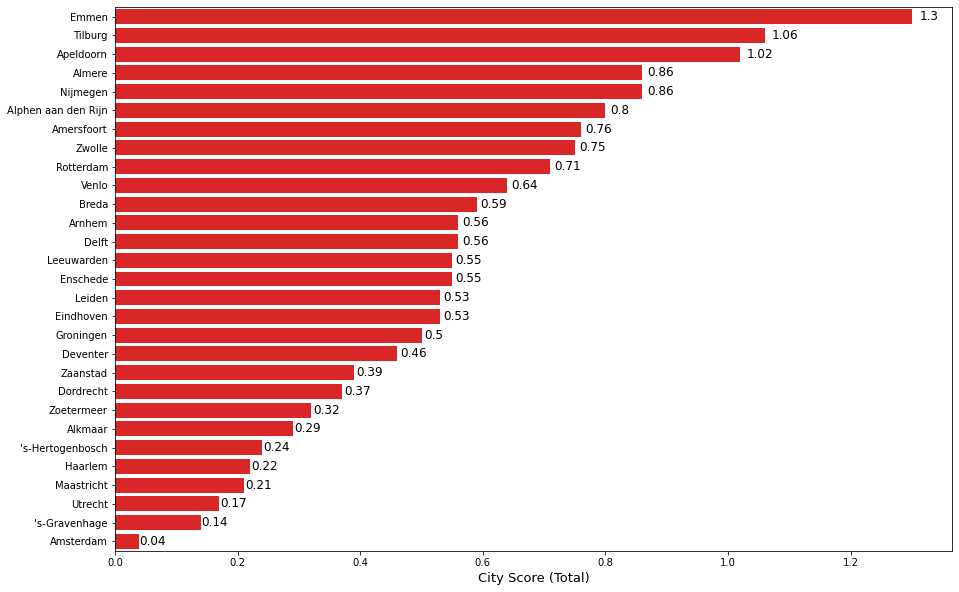

In [64]:
#Plot all municipalities and their total (model 1+ 2+ 3 ) suitability scores
Normalized.sort_values(by= 'CityScore', ascending = False, inplace=True)
plt.figure(figsize=(15, 10)) 
ax = sns.barplot(y=Normalized['Municipalities'], x=Normalized['CityScore'], orient= 'h', color = 'red', saturation = 0.7)
#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
plt.xlabel('City Score (Total)', fontdict= {'fontsize': 13})
plt.ylabel('')

#add value at top of bar
for pY, pX in enumerate(Normalized['CityScore']):
    ax.annotate(round(pX,2), xy=(pX*1.01,pY), fontsize = 12, va='center')


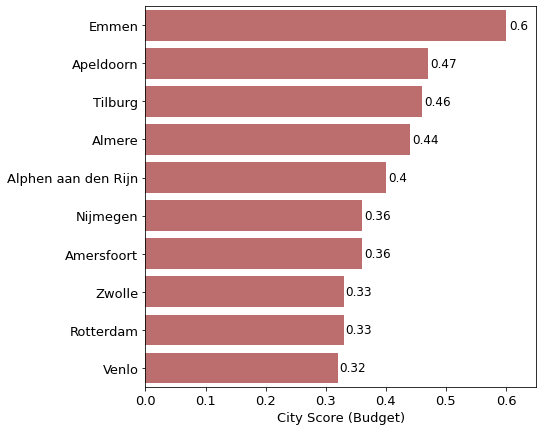

In [65]:
#Plot all municipalities and  suitability budget
Normalized.sort_values(by= 'CityScoreBudgetCorr', ascending = False, inplace=True)
plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=Normalized['Municipalities'][0:10], x=Normalized['CityScoreBudgetCorr'], orient= 'h', color = 'indianred', saturation = 0.7)
#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,0.65))

plt.xlabel('City Score (Budget)', fontdict= {'fontsize': 13})
plt.ylabel('')

#add value at top of bar
for pY, pX in enumerate(Normalized['CityScoreBudgetCorr'][0:10]):
    ax.annotate(round(pX,2), xy=(pX*1.01,pY), fontsize = 12, va='center')


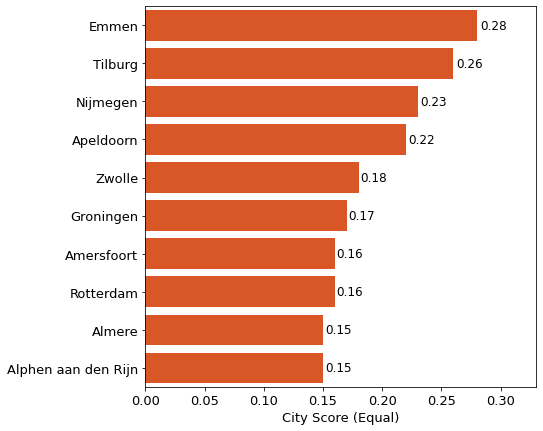

In [66]:
#Plot all municipalities and  suitability equal
Normalized.sort_values(by= 'CityScoreEqualCorr', ascending = False, inplace=True)
plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=Normalized['Municipalities'][0:10], x=Normalized['CityScoreEqualCorr'], orient= 'h', color = 'orangered', saturation = 0.7)
#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,0.33))

plt.xlabel('City Score (Equal)', fontdict= {'fontsize': 13})
plt.ylabel('')

#add value at top of bar
for pY, pX in enumerate(Normalized['CityScoreEqualCorr'][0:10]):
    ax.annotate(round(pX,2), xy=(pX*1.01,pY), fontsize = 12, va='center')


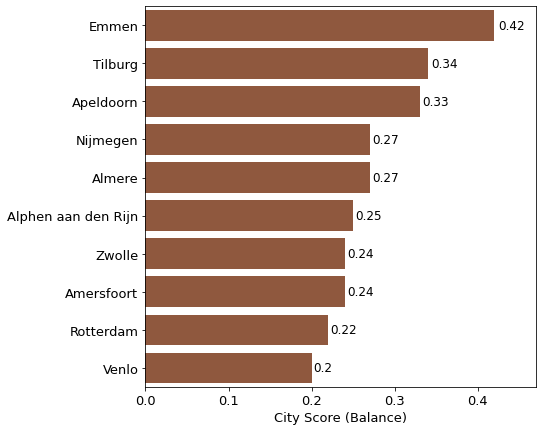

In [67]:
#Plot all municipalities and  suitability equal
Normalized.sort_values(by= 'CityScoreBalanceCorr', ascending = False, inplace=True)
plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=Normalized['Municipalities'][0:10], x=Normalized['CityScoreBalanceCorr'], orient= 'h', color = 'sienna', saturation = 0.7)
#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,0.47))

plt.xlabel('City Score (Balance)', fontdict= {'fontsize': 13})
plt.ylabel('')

#add value at top of bar
for pY, pX in enumerate(Normalized['CityScoreBalanceCorr'][0:10]):
    ax.annotate(round(pX,2), xy=(pX*1.01,pY), fontsize = 12, va='center')


In [68]:
#show all municipalities on the map with a tag

# define map of the Netherlands map 
NL_map = folium.Map(location=[52.218, 5.538], zoom_start=7.4, tiles='OpenStreetMap')
# instantiate a feature group for the incidents in the dataframe 
incidents = folium.map.FeatureGroup()
# loop through the municipalities 
for lat, lng, in zip(df['Latitude'], df['Longitude']): 
    incidents.add_child( 
        folium.features.CircleMarker( [lat, lng], 
            radius=2, # define how big you want the circle markers to be 
            color='black', 
            fill=False, 
            fill_color='black', 
            fill_opacity=0.6 )) 
 # add incidents to map 
NL_map.add_child(incidents)

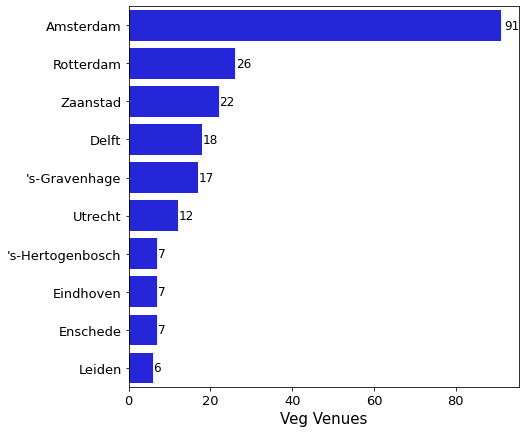

In [69]:
#Plot number of veg venues
plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df['Municipalities'][0:10], x=df['VegVenues'][0:10], orient= 'h', color = 'blue', saturation = 0.7)
#plt.title('Number of Veg Venues per city', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
plt.xlabel('Veg Venues', fontdict= {'fontsize': 15})
plt.ylabel('')

#add value at top of bar
for pY, pX in enumerate(df['VegVenues'][0:10]):
    ax.annotate(round(pX,2), xy=(pX*1.01,pY), fontsize = 12, va='center')



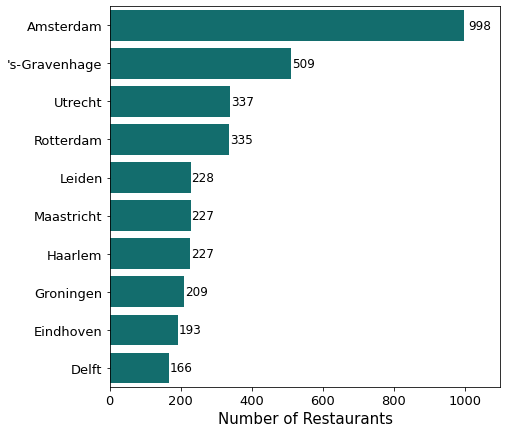

In [70]:
#Plot number of total venues
df = df.sort_values(by= 'TotalVenues', ascending = False)

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df['Municipalities'][0:10], x=df['TotalVenues'][0:10], orient= 'h', color = 'teal', saturation = 0.7)
#plt.title('Number of Veg Venues per city', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,1100))
plt.xlabel('Number of Restaurants', fontdict= {'fontsize': 15})
plt.ylabel('')

#add value at top of bar
for pY, pX in enumerate(df['TotalVenues'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


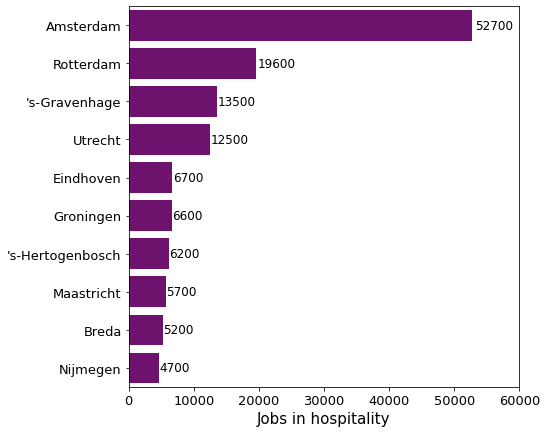

In [71]:
#Plot Jobs in hospitality 
df = df.sort_values(by= 'JobsInHospitality', ascending = False)

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df['Municipalities'][0:10], x=df['JobsInHospitality'][0:10], orient= 'h', color = 'purple', saturation = 0.7)
#plt.title('Number of Veg Venues per city', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,60000))
plt.xlabel('Jobs in hospitality', fontdict= {'fontsize': 15})
plt.ylabel('')


#add value at top of bar
for pY, pX in enumerate(df['JobsInHospitality'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


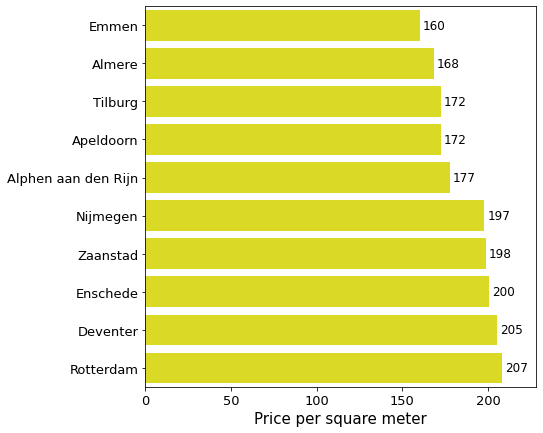

In [72]:
#Plot retail price per M2 
df = df.sort_values(by= 'RetailPriceM2')

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df['Municipalities'][0:10], x=df['RetailPriceM2'][0:10], orient= 'h', color = 'yellow', saturation = 0.7)
#plt.title('Number of Veg Venues per city', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,228))
plt.xlabel('Price per square meter', fontdict= {'fontsize': 15})
plt.ylabel('')


#add value at top of bar
for pY, pX in enumerate(df['RetailPriceM2'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


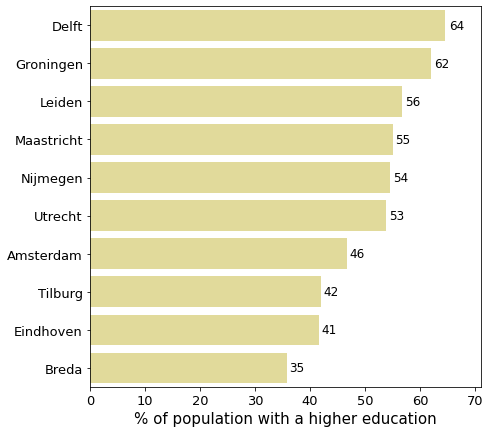

In [73]:
#Plot HigherEdu
df = df.sort_values(by= 'HigherEdu', ascending = False)

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df['Municipalities'][0:10], x=df['HigherEdu'][0:10], orient= 'h', color = 'khaki', saturation = 0.7)
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,71))
plt.xlabel('% of population with a higher education', fontdict= {'fontsize': 15})
plt.ylabel('')


#add value at top of bar
for pY, pX in enumerate(df['HigherEdu'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


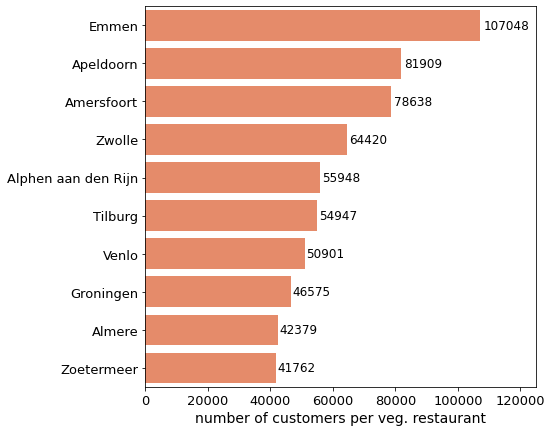

In [74]:
#Plot direct competition
df2 = df2.sort_values(by= 'VegRestaurantDensity', ascending = False)

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df2['Municipalities'][0:10], x=df2['VegRestaurantDensity'][0:10], orient= 'h', color = 'coral', saturation = 0.7)
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,125000))
plt.xlabel('number of customers per veg. restaurant', fontdict= {'fontsize': 14})
plt.ylabel('')


#add value at top of bar
for pY, pX in enumerate(df2['VegRestaurantDensity'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


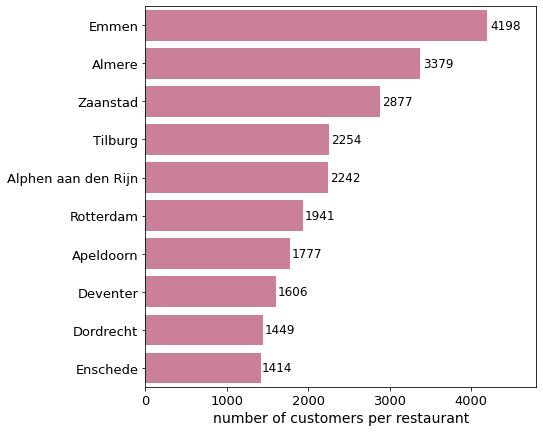

In [75]:
#Plot indirect competition
df2 = df2.sort_values(by= 'TotRestaurantDensity', ascending = False)

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df2['Municipalities'][0:10], x=df2['TotRestaurantDensity'][0:10], orient= 'h', color = 'palevioletred', saturation = 0.7)
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,4800))
plt.xlabel('number of customers per restaurant', fontdict= {'fontsize': 14})
plt.ylabel('')


#add value at top of bar
for pY, pX in enumerate(df2['TotRestaurantDensity'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


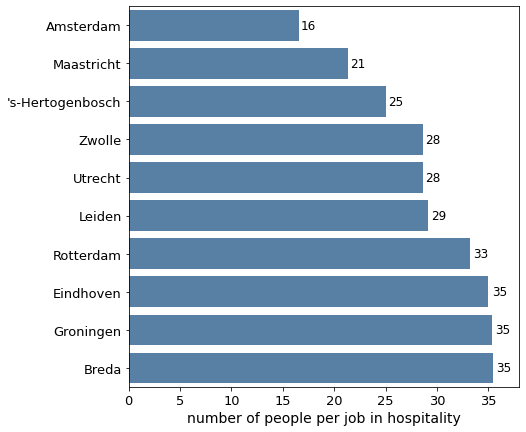

In [76]:
#Plot Tourism Index
df2 = df2.sort_values(by= 'TourismIndex')

plt.figure(figsize=(7, 7)) 
ax = sns.barplot(y=df2['Municipalities'][0:10], x=df2['TourismIndex'][0:10], orient= 'h', color = 'steelblue', saturation = 0.7)
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(xlim=(0,38))
plt.xlabel('number of people per job in hospitality', fontdict= {'fontsize': 14})
plt.ylabel('')


#add value at top of bar
for pY, pX in enumerate(df2['TourismIndex'][0:10]):
    ax.annotate(int(pX), xy=(pX*1.01,pY), fontsize = 12, va='center')


## 10. Post Model Analysis of top 5 cities Visualisation

In [77]:
#create a new df with only the top 5 cities and invert negative values
Normalized.sort_values(by = 'CityScore', ascending = False)
selection = Normalized[['Municipalities','RetailPriceM2', 'VegRestaurantDensity', 'TotRestaurantDensity', 'TourismIndex', 'HigherEdu']].head()
selection['RetailPriceM2Corr'] =  1 - selection['RetailPriceM2']
selection['TourismIndexCorr'] =  1 - selection['TourismIndex']
selection['TourismIndexCorr'] = round(selection['TourismIndexCorr'],6)

In [78]:
selection

,Municipalities,RetailPriceM2,VegRestaurantDensity,TotRestaurantDensity,TourismIndex,HigherEdu,RetailPriceM2Corr,TourismIndexCorr
28,Emmen,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
20,Tilburg,0.067564,0.485641,0.469577,0.569343,0.579143,0.932436,0.430657
23,Apeldoorn,0.068113,0.751819,0.339427,0.392336,0.080074,0.931887,0.607664
12,Nijmegen,0.207635,0.293969,0.209823,0.386861,0.813780,0.792365,0.613139
11,Almere,0.044768,0.361565,0.776535,0.833942,0.102421,0.955232,0.166058


Text(0.5, 1.0, 'Cheapest retail prices')

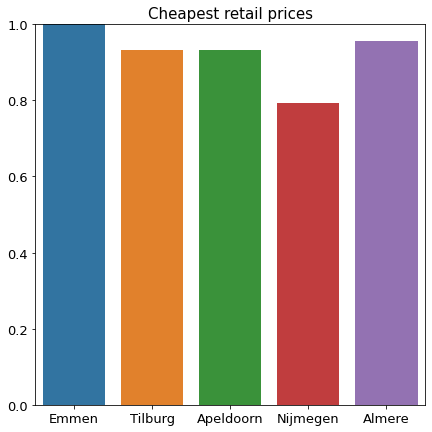

In [79]:
#Plot normalized Rent scores for the top 5 cities.

plt.figure(figsize = (7,7)) 
ax= sns.barplot(x= 'Municipalities', y= 'RetailPriceM2Corr',  data= selection)


#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(ylim=(0,1))
plt.xlabel('', fontdict= {'fontsize': 15})
plt.ylabel('', fontdict= {'fontsize': 15})
plt.title('Cheapest retail prices', fontdict= {'fontsize': 15})




Text(0.5, 1.0, 'Places with the least direct competition')

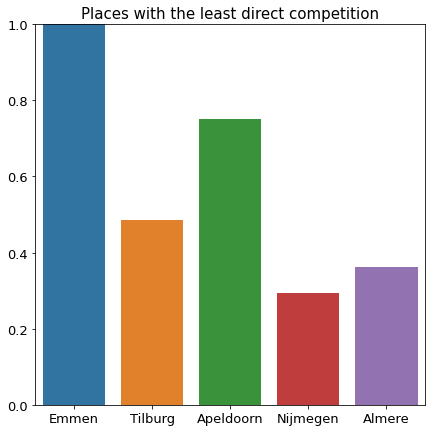

In [80]:
#Plot normalized Direct competition scores for the top 5 cities.

plt.figure(figsize = (7,7)) 
ax= sns.barplot(x= 'Municipalities', y= 'VegRestaurantDensity',  data= selection)


#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(ylim=(0,1))
plt.xlabel('', fontdict= {'fontsize': 15})
plt.ylabel('', fontdict= {'fontsize': 15})
plt.title('Places with the least direct competition', fontdict= {'fontsize': 15})



Text(0.5, 1.0, 'Places with the least indirect competition')

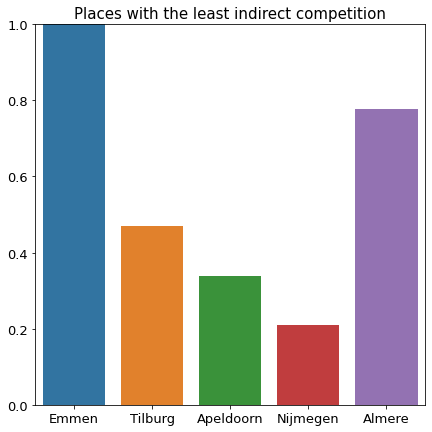

In [81]:
#Plot normalized Indirect competition scores for the top 5 cities.

plt.figure(figsize = (7,7)) 
ax= sns.barplot(x= 'Municipalities', y= 'TotRestaurantDensity',  data= selection)


#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
ax.set(ylim=(0,1))
plt.xlabel('', fontdict= {'fontsize': 15})
plt.ylabel('', fontdict= {'fontsize': 15})
plt.title('Places with the least indirect competition', fontdict= {'fontsize': 15})


[(0.0, 1.0)]

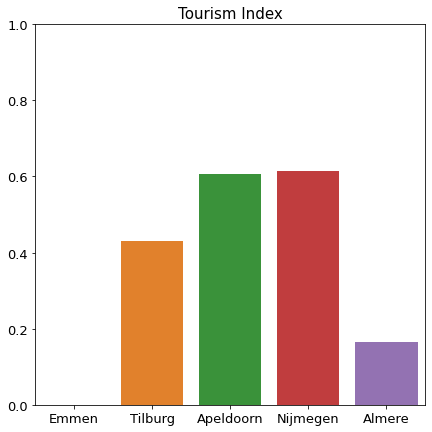

In [82]:
#Plot normalized Tourism scores for the top 5 cities.

plt.figure(figsize = (7,7)) 
ax= sns.barplot(x= 'Municipalities', y= 'TourismIndexCorr',  data= selection)


#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
plt.xlabel('', fontdict= {'fontsize': 15})
plt.ylabel('', fontdict= {'fontsize': 15})
plt.title('Tourism Index', fontdict= {'fontsize': 15})
ax.set(ylim=(0,1))




[(0.0, 1.0)]

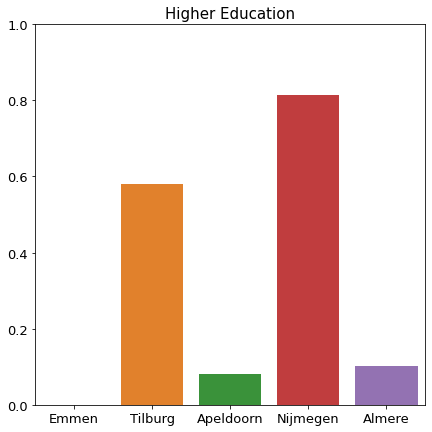

In [83]:
#Plot normalized Eductaion scores for the top 5 cities.

plt.figure(figsize = (7,7)) 
ax= sns.barplot(x= 'Municipalities', y= 'HigherEdu',  data= selection)


#plt.title('Suitability scores for opening a vegetarian or vegan restaurant', fontdict= {'fontsize': 20}) # add title to the plot 
mpl.rc('ytick', labelsize=13)
mpl.rc('xtick', labelsize=13)
plt.xlabel('', fontdict= {'fontsize': 15})
plt.ylabel('', fontdict= {'fontsize': 15})
plt.title('Higher Education', fontdict= {'fontsize': 15})
ax.set(ylim=(0,1))